In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
sns.set(rc = {'figure.figsize':(10, 6)})
pd.set_option("precision", 3)

In [2]:
folder = "/home/jarobyte/scratch/guemes/icdar/pl/baseline/experiments/"

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [3]:
files = os.listdir(folder)
len(files)

24

In [4]:
logs = pd.concat([pd.read_csv(folder + f) 
                       for f in tqdm(os.listdir(folder))])\
.assign(dropout = lambda df: df.dropout.round(2))
print(logs.shape)
logs.head()

  0%|          | 0/24 [00:00<?, ?it/s]

(1091, 21)


,epoch,train_loss,train_error_rate,dev_loss,dev_error_rate,training_minutes,learning_rate,weight_decay,model,max_sequence_length,...,feedforward_dimension,encoder_layers,decoder_layers,attention_heads,activation,dropout,parameters,encoder_tokens,decoder_tokens,experiment_id
0,1,1.634,44.362,0.900,25.230,3.951,1.000e-04,0.0,Transformer,110,...,1024,4,4,8,relu,0.0,7555015,199,199,22717211_3
1,2,0.674,21.266,0.917,24.051,7.948,1.000e-04,0.0,Transformer,110,...,1024,4,4,8,relu,0.0,7555015,199,199,22717211_3
2,3,0.329,12.205,1.219,25.451,11.918,1.000e-04,0.0,Transformer,110,...,1024,4,4,8,relu,0.0,7555015,199,199,22717211_3
3,4,0.145,6.757,1.481,25.600,15.892,1.000e-04,0.0,Transformer,110,...,1024,4,4,8,relu,0.0,7555015,199,199,22717211_3
4,5,0.086,5.084,1.699,25.832,19.875,1.000e-04,0.0,Transformer,110,...,1024,4,4,8,relu,0.0,7555015,199,199,22717211_3


In [5]:
experiments = logs\
.assign(fit = lambda df: df.apply(lambda r: {k:r[k] for k in ["train_loss", 
                                                              "dev_loss", 
                                                              "epoch"]}, 
                                  axis = 1))\
.groupby("experiment_id")\
.agg({"fit":(lambda x: min(x, key = lambda y: y["dev_loss"])),
      "parameters":max, 
      "dropout":max,
      "weight_decay":max,
      "embedding_dimension":max,
      "encoder_layers":max,
      "training_minutes":max})\
.assign(parameters = lambda df: df.parameters / 10**6, 
        train_loss = lambda df: df.fit.map(lambda x: x["train_loss"]),
        dev_loss = lambda df: df.fit.map(lambda x: x["dev_loss"]),
        epoch = lambda df: df.fit.map(lambda x: x["epoch"]))\
.drop(columns = "fit")
experiments.head(10)

,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
experiment_id,,,,,,,,,
22697248_1,7.555,0.4,1.000e-03,256,4,203.304,2.051,2.186,46
22697248_10,7.555,0.1,1.000e-03,256,4,200.843,0.716,0.850,20
22697248_11,7.555,0.1,1.000e-04,256,4,201.686,0.689,0.635,3
22697248_12,7.555,0.3,1.000e-04,256,4,204.666,0.578,0.594,10
22697248_2,7.555,0.3,1.000e-02,256,4,200.440,2.516,2.629,47
22697248_3,7.555,0.2,1.000e-02,256,4,200.457,2.502,2.626,46
22697248_4,7.555,0.5,1.000e-02,256,4,203.057,2.518,2.644,43
22697248_5,7.555,0.1,1.000e-02,256,4,201.004,2.474,2.606,45
22697248_6,7.555,0.3,1.000e-03,256,4,209.110,1.894,2.110,44


# evaluation

In [6]:
evaluation_folder = "/home/jarobyte/scratch/guemes/icdar/pl/baseline/evaluation/"

In [7]:
evaluation_files = os.listdir(evaluation_folder)
len(evaluation_files)

24

In [8]:
evaluation = pd.concat([pd.read_csv(evaluation_folder + f) 
                       for f in tqdm(os.listdir(evaluation_folder))])
print(evaluation.shape)
evaluation.head()

  0%|          | 0/24 [00:00<?, ?it/s]

(240, 9)


,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting
0,22697248_2,-168.826,disjoint,greedy,100,4.278,29.952,80.518,NaN
1,22697248_2,-155.921,disjoint,greedy,50,2.132,29.952,76.653,NaN
2,22697248_2,-199.775,disjoint,beam,100,11.093,29.952,89.788,NaN
3,22697248_2,-184.141,disjoint,beam,50,7.671,29.952,85.105,NaN
4,22697248_2,-162.561,sliding,greedy,50,41.440,29.952,78.642,uniform


In [9]:
results = evaluation.merge(experiments, right_index = True, left_on = "experiment_id")\
.sort_values("improvement", ascending = False)
results.head()

,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
4,22717211_8,22.163,sliding,greedy,50,44.187,29.952,23.313,uniform,7.555,0.0,0.000e+00,256,4,187.364,0.631,0.735,2
5,22717211_8,20.803,sliding,greedy,50,43.872,29.952,23.721,triangle,7.555,0.0,0.000e+00,256,4,187.364,0.631,0.735,2
6,22717211_8,20.340,sliding,greedy,50,43.459,29.952,23.860,bell,7.555,0.0,0.000e+00,256,4,187.364,0.631,0.735,2
4,22697248_12,19.814,sliding,greedy,50,43.609,29.952,24.017,uniform,7.555,0.3,1.000e-04,256,4,204.666,0.578,0.594,10
6,22697248_12,19.667,sliding,greedy,50,43.828,29.952,24.061,bell,7.555,0.3,1.000e-04,256,4,204.666,0.578,0.594,10


<AxesSubplot:>

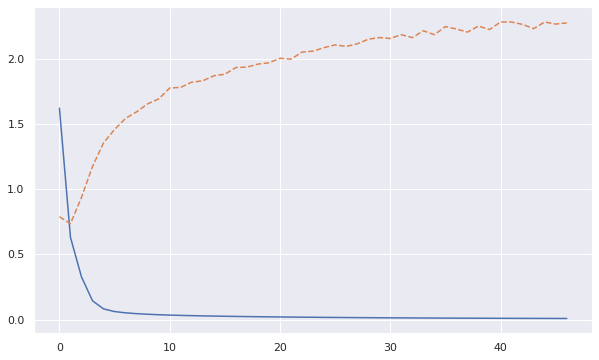

In [10]:
logs.query("experiment_id == '22717211_8'").train_loss.plot()
logs.query("experiment_id == '22717211_8'").dev_loss.plot(ls = "--")

In [11]:
results.query("experiment_id == '22717211_8'")\
[["experiment_id", "window", "window_size", "decoding", "weighting", "improvement"]]\
.sort_values(["window", "window_size", "decoding", "weighting"])\
.pivot(index = "experiment_id", 
       values = "improvement", 
       columns = ["window", "window_size", "decoding", "weighting"])

window        disjoint                        sliding                          \
window_size        50              100            50                            
decoding          beam  greedy    beam greedy    beam                  greedy   
weighting          NaN     NaN     NaN    NaN    bell triangle uniform   bell   
experiment_id                                                                   
22717211_8     -40.976 -33.247 -24.528  2.223  16.156   16.054  17.244  20.34   

window                          
window_size                     
decoding                        
weighting     triangle uniform  
experiment_id                   
22717211_8      20.803  22.163